In [97]:
import os
import sys
from pathlib import Path
import json
import gzip
from glob import glob
import tarfile
import re
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter
from pymatgen.core import Structure

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.1
1.3.5


In [4]:
import nfp
print(nfp.__version__)
from nfp import custom_objects
from nfp.layers import RBFExpansion
from nfp.preprocessing.crystal_preprocessor import PymatgenPreprocessor

2022-05-10 11:01:37.493516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-05-10 11:01:37.493549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.6


In [5]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

2.7.0


In [6]:
os.chdir('../')

In [58]:
import os
# os.chdir('../')
base_dir = "/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork"
os.chdir("/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork")
from src import utils
import eval_test

### Load the unrelaxed and relaxed structures from the MCTS runs

In [114]:
mcts_outputs = [
    {"run_id": "20220504/batt-icsd-volpred-KLiNa",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/best_decorations.p", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/decomp_energy.csv",
     # "relaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/best_decorations.p",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation_05122022/relaxed_structures_2/",
    },
    {"run_id": "20220504/batt-volpred-KLiNa",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/volpred-KLiNa/best_decorations.p", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/volpred-KLiNa/decomp_energy.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation_05122022/relaxed_structures_3/",
    },
    {"run_id": "20220509-rel-energy-cos-dist0.1-eles3-Li",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-09-batt-icsd-cos-dist-Li/best_decorations.p", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-05-09-batt-icsd-cos-dist-Li/decomp_energy.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation_05122022/relaxed_structures_1/",
    },
    # 20220422-batt-icsd-volpred-combined
    {"run_id": "2022-04-27-batt-icsd-vol-combined",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined/best_decorations.p", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined/viz/pred_vs_dft.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation_04282022/relaxed_structures.tar.gz",
    },
    # 20220422-batt-icsd-vol-2 - combined
    {"run_id": "2022-04-26-batt-icsd-vol-combined",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-26-batt-icsd-vol-combined/best_decorations", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-26-batt-icsd-vol-combined/viz/pred_vs_dft.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation_04262022/relaxed_structures.tar.gz",
    },
    # 2022-01-25-run4
    {"run_id": "2022-01-25-run4",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-01-25-run4/all", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-01-25-run4/viz/pred_vs_dft.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation/relaxed4-structure",
    },
    # 2022-01-21-run2-3
    {"run_id": "2022-01-21-run2-3",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-01-21-run2-3/all", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-01-21-run2-3/viz/pred_vs_dft.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation/relaxed2-structure",
    },
    # 2022-01-18-run1
    {"run_id": "2022-01-18-run1",
     "unrelaxed_strcs": "/projects/rlmolecule/jlaw/crystal_outputs/2022-01-18-run1/rel-energy-cos-dist0.1-eles3-combined-rew1", 
     "decomp_energy_file": "/projects/rlmolecule/jlaw/crystal_outputs/2022-01-18-run1/viz/pred_vs_dft.csv",
     "relaxed_strcs_dir": "/projects/rlmolecule/pgorai/mcts_validation/relaxed-structure",
    },
]


In [106]:
def extract_strc_from_tar(tar, filename):
    f = tar.extractfile(filename)
    contents = f.read().decode()
    strc = Structure.from_str(contents, fmt='poscar')
    return strc

In [171]:
# load the structures from each MCTS run
run_data = pd.DataFrame()
for i, run in enumerate(mcts_outputs):
    print(run['run_id'])
    if run['unrelaxed_strcs'].endswith('.p'):
        unrelaxed_strcs = pd.read_pickle(run['unrelaxed_strcs'])
        unrelaxed_strcs.rename(columns={"structure": "unrel_structure"}, inplace=True)
    # must be a directory, so load each structure
    else:
        unrelaxed_strcs = {}
        for f in tqdm(glob(f"{run['unrelaxed_strcs']}/POSCAR*")):
            strc = Structure.from_file(f, primitive=True)
            strc_id = os.path.basename(f).replace("POSCAR_", "")
            unrelaxed_strcs[strc_id] = strc
        unrelaxed_strcs = pd.Series(unrelaxed_strcs)
    
    energy_data = pd.read_csv(run['decomp_energy_file'], index_col=0)
    if 'id' not in energy_data.columns:
        energy_data = energy_data.reset_index().rename(columns={"index": 'id'})
    # print(energy_data.head(2))
    # data = pd.merge(unrelaxed_strcs.set_index(unrelaxed_strcs.columns[0])
    if run['unrelaxed_strcs'].endswith('.p'):
        data = pd.merge(unrelaxed_strcs, energy_data, left_on='id', right_on='id', suffixes=('', '_y'))
        data.set_index('id', inplace=True)
    else:
        data = energy_data.set_index('id')
        data['unrel_structure'] = unrelaxed_strcs
    
    # now load the relaxed structures
    if 'relaxed_strcs_dir' in run:
        relaxed_strcs = {}
        failed = set()
        if run['relaxed_strcs_dir'].endswith('.tar.gz'):
            with tarfile.open(run['relaxed_strcs_dir'], "r:gz") as tar:
                for tarinfo in tar:
                    # print(f"{tarinfo.name} is {tarinfo.size} bytes in size and is: ")
                    if len(tarinfo.name.split('/')) == 3:
                        strc_id = tarinfo.name.split('/')[-1]
                        # print(strc_id)
                    if str(tarinfo.name).endswith("POSCAR"):
                        try:
                            strc = extract_strc_from_tar(tar, tarinfo.name)
                            relaxed_strcs[strc_id] = strc
                        except ValueError:
                            failed.add(strc_id)
                    if str(tarinfo.name).endswith("CONTCAR"):
                        raise ValueError("Was not expecting CONTCAR")
                    # TODO check for "distance between some ions is very small"
        else:
            strc_files = list(glob(f"{run['relaxed_strcs_dir']}/*/*/POSCAR"))
            if len(strc_files) == 0:
                strc_files = list(glob(f"{run['relaxed_strcs_dir']}/*/*/CONTCAR"))
                
            for f in tqdm(strc_files):
                strc = Structure.from_file(f, primitive=True)
                strc_id = f.split('/')[-2]
                relaxed_strcs[strc_id] = strc
        relaxed_strcs = pd.Series(relaxed_strcs)
        print(relaxed_strcs.head(2))
        data['rel_structure'] = relaxed_strcs
    
    data['run_id'] = run['run_id']
    
    run_data = pd.concat([run_data, data])
    # break
    
run_data.tail(2)

20220504/batt-icsd-volpred-KLiNa


  0%|          | 0/37 [00:00<?, ?it/s]

Li1Sc1F4_sg13_icsd_082364_1    [[2.40109714 2.05559953 1.36646387] Li, [2.361...
K1Sc1Br4_sg63_icsd_060615_1    [[ 5.46534134 10.87846906  2.59923626] K, [5.4...
dtype: object
20220504/batt-volpred-KLiNa


  0%|          | 0/27 [00:00<?, ?it/s]

K2Y1Br5_sg166_icsd_084763_1    [[2.60108470e+00 4.50521157e+00 1.06315370e-07...
Li1Sc1F4_sg65_icsd_016492_2    [[5.08638221 2.55256789 2.5639804 ] Sc, [2.543...
dtype: object
20220509-rel-energy-cos-dist0.1-eles3-Li


  0%|          | 0/13 [00:00<?, ?it/s]

Li1Sc1F4_sg82_icsd_044801_1        [[ 2.55732632e+00 -2.10689158e-05  4.10320904e...
Li1Sc2Br6I1_sg225_icsd_033621_1    [[5.29254802 5.29254769 5.29254782] I, [ 5.292...
dtype: object
2022-04-27-batt-icsd-vol-combined
Na1Cd1Cl1Br2_sg140_icsd_411137_3    [[4.10904090e+00 1.54345452e-07 2.33230702e+00...
Li2F1Cl1_sg180_icsd_090403_1        [[1.51283716 2.62030625 5.53769908] F, [ 3.025...
dtype: object
2022-04-26-batt-icsd-vol-combined


  0%|          | 0/378 [00:00<?, ?it/s]

Na5Cl1I4_sg81_icsd_407646_1     [[1.89749185 6.20028484 3.7026767 ] Cl, [8.679...
Li2F1Cl1_sg198_icsd_166256_2    [[1.87325965 4.12151583 4.00667123] Cl, [4.954...
dtype: object
2022-01-25-run4


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Mg1P1Sb1O5S1_sg62_icsd_281591_16    [[8.30045734 2.50599134 5.1990762 ] Mg, [4.086...
Mg1P1Sb1O5S1_sg62_icsd_281591_8     [[3.26140598 1.87762498 3.98081059] P, [9.7099...
dtype: object
2022-01-21-run2-3


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

Li1Sc1F4_sg141_icsd_020383_2    [[6.65152483 3.32576112 4.77256248] Li, [6.651...
Li1Sc1F4_sg59_icsd_054122_2     [[3.14834647 4.83330749 4.79082002] Li, [6.296...
dtype: object
2022-01-18-run1


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

Li1Sc1F4_sg119_icsd_162670_1    [[2.42186886 0.27909996 7.42731144] Sc, [0.347...
Li1Sc1F4_sg216_icsd_002457_1    [[2.09511943 2.09511979 6.28535932] Li, [2.095...
dtype: object


,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,unrel_structure,dls_volume,energyperatom,decomp_energy,rel_structure,...,volume,decoration,numatoms,relaxedvolume,comp_y,pred_energyperatom_y,pred_decomp_energy_y,ediff,cos_dist,Cosine Dist.
id,,,,,,,,,,,,,,,,,,,,,
Zn1Sc1F4I1_sg216_icsd_020805_6,NaN,NaN,-1.253,-4.861718,NaN,"[[0. 0. 0.] I, [0. 4.159 4.159] I, [4.159 0...",NaN,-4.768521,-1.159,"[[8.98567524 8.9856744 8.98567361] I, [8.9856...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000036,<= .1
Na1Y2Br7_sg225_icsd_260147_1,NaN,NaN,-1.083,-3.890865,NaN,"[[0. 0. 0.] Na, [0. 4.115 4.115] Na, [4.115...",NaN,-3.820848,-1.013,[[1.41675389e-06 2.34991617e-06 5.90017262e-06...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304213,> .1


In [172]:
run_data.columns

Index(['decor_id', 'reward', 'pred_decomp_energy', 'pred_energyperatom',
       'comp', 'unrel_structure', 'dls_volume', 'energyperatom',
       'decomp_energy', 'rel_structure', 'run_id', 'volume', 'decoration',
       'numatoms', 'relaxedvolume', 'comp_y', 'pred_energyperatom_y',
       'pred_decomp_energy_y', 'ediff', 'cos_dist', 'Cosine Dist.'],
      dtype='object')

In [173]:
cols_to_keep = ['run_id', 'comp', 'energyperatom', 'decomp_energy', 'reward', 'unrel_structure', 'rel_structure']
run_data = run_data[cols_to_keep]
run_data.head(2)

,run_id,comp,energyperatom,decomp_energy,reward,unrel_structure,rel_structure
id,,,,,,,
K1Al2Br7_sg14_icsd_200871_1,20220504/batt-icsd-volpred-KLiNa,K1Al2Br7,-3.291,-1.087,1.045,"[[ 4.02869029 8.40396858 11.17619603] Al, [ 1...","[[ 4.12377755 8.73829064 10.7814738 ] Al, [ 1..."
K1Hf1Br5_sg62_icsd_418675_1,20220504/batt-icsd-volpred-KLiNa,K1Hf1Br5,-4.008,-1.179,1.141,"[[10.45793139 5.98740196 9.68849231] K, [2.8...","[[11.61457197 5.78901635 8.17100474] K, [3.5..."


In [175]:
print(len(run_data), len(run_data.dropna(subset=["unrel_structure", "energyperatom", "decomp_energy"])))

1296 1296


In [176]:
# one more previous run to load
run_id = "20211021-icsd-batt-unrel"
energy_df = pd.read_csv("/projects/rlmolecule/jlaw/logs/crystal_energy/hull_energy_batt_origlatt/relaxation_energy_Oct25.csv", index_col=0)
unrelaxed_strcs = {}
for f in tqdm(glob(f"/projects/rlmolecule/jlaw/logs/crystal_energy/hull_energy_batt_origlatt/best_decor_per_comp_rew2/POSCAR*")):
    strc = Structure.from_file(f, primitive=True)
    strc_id = os.path.basename(f).replace("POSCAR_", "")
    unrelaxed_strcs[strc_id] = strc
unrelaxed_strcs = pd.Series(unrelaxed_strcs)

# now load the relaxed structures
relaxed_strcs = {}
for f in tqdm(glob(f"/scratch/jiaxing/RL/relaxation/relaxed/POSCAR*/CONTCAR")):
    strc = Structure.from_file(f, primitive=True)
    strc_id = os.path.basename(os.path.dirname(f)).replace("POSCAR_", "")
    relaxed_strcs[strc_id] = strc
relaxed_strcs = pd.Series(relaxed_strcs)

energy_df['unrel_structure'] = unrelaxed_strcs
energy_df['rel_structure'] = relaxed_strcs
energy_df['comp'] = energy_df.index.map(lambda x: x.split('_')[0])
energy_df.head(2)

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

,total_energy,number of atoms in the structure,energyperatom,unrel_structure,rel_structure,comp
id,,,,,,
Zn4Sn1P4_sg1_icsd_079005_2,-31.157697,9,-3.461966,"[[4.09526316 2.06657517 0.66288569] Zn, [3.731...","[[4.55645676 3.55017525 1.40334204] Zn, [5.402...",Zn4Sn1P4
Li1Y1Zn4P4_sg4_icsd_075430_3,-75.979688,20,-3.798984,"[[4.19441415 6.2399376 1.27151265] Y, [0.2086...","[[3.90191404 6.35150696 0.81608624] Y, [0.1068...",Li1Y1Zn4P4


In [188]:
print(len(energy_df))
print(len(energy_df.replace({np.nan, None}).dropna()))

125
125


In [127]:
# now compute the decomposition energies

In [128]:
def compute_decomp_energy(row):
    comp, energyperatom = row.comp, row.energyperatom
    # update: if the composition is in the competing phases,
    # then just compare the predicted energy to the energy of the competing phase
    if comp in df_competing_phases['reduced_composition']:
        competing_energy = df_competing_phases.set_index(
            'reduced_composition').loc[comp].energyperatom
        decomp_energy = energyperatom - competing_energy
    else:
        decomp_energy = ehull.convex_hull_stability(comp,
                                                    energyperatom,
                                                    df_competing_phases)
    return decomp_energy

In [177]:
# Dataframe containing competing phases from NRELMatDB
competing_phases_file = "/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv"
print(f"Reading {competing_phases_file}")
df_competing_phases = pd.read_csv(competing_phases_file)
print(f"\t{len(df_competing_phases)} lines")
print(df_competing_phases.head(2))

Reading /home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4


In [178]:
energy_df['decomp_energy'] = energy_df.progress_apply(compute_decomp_energy, axis=1)
energy_df.head(2)

  0%|          | 0/125 [00:00<?, ?it/s]

,total_energy,number of atoms in the structure,energyperatom,unrel_structure,rel_structure,comp,decomp_energy
id,,,,,,,
Zn4Sn1P4_sg1_icsd_079005_2,-31.157697,9,-3.461966,"[[4.09526316 2.06657517 0.66288569] Zn, [3.731...","[[4.55645676 3.55017525 1.40334204] Zn, [5.402...",Zn4Sn1P4,0.127
Li1Y1Zn4P4_sg4_icsd_075430_3,-75.979688,20,-3.798984,"[[4.19441415 6.2399376 1.27151265] Y, [0.2086...","[[3.90191404 6.35150696 0.81608624] Y, [0.1068...",Li1Y1Zn4P4,0.137


In [179]:
run_data = pd.concat([run_data, energy_df[['energyperatom', 'unrel_structure', 'rel_structure', 'comp', 'decomp_energy']]])

In [198]:
important_cols = ["unrel_structure", "rel_structure", "energyperatom", "decomp_energy"]
print(len(run_data), len(run_data.dropna(subset=important_cols)))
run_data = run_data.dropna(subset=important_cols)

1421 1406


In [199]:
# make sure other relevant info is present
run_data['num_sites'] = run_data.rel_structure.apply(lambda x: len(x.sites))
run_data['volume'] = run_data.rel_structure.apply(lambda x: x.volume)
run_data['unrel_volume'] = run_data.unrel_structure.apply(lambda x: x.volume)
run_data['comp'] = run_data.index.map(lambda x: x.split('_')[0])
run_data['proto_id'] = run_data.index.map(lambda x: f"icsd_{x.split('_')[-2]}")
run_data.head(2)

,run_id,comp,energyperatom,decomp_energy,reward,unrel_structure,rel_structure,num_sites,volume,unrel_volume,proto_id
id,,,,,,,,,,,
K1Al2Br7_sg14_icsd_200871_1,20220504/batt-icsd-volpred-KLiNa,K1Al2Br7,-3.291,-1.087,1.045,"[[ 4.02869029 8.40396858 11.17619603] Al, [ 1...","[[ 4.12377755 8.73829064 10.7814738 ] Al, [ 1...",40,1844.334991,1884.372704,icsd_200871
K1Hf1Br5_sg62_icsd_418675_1,20220504/batt-icsd-volpred-KLiNa,K1Hf1Br5,-4.008,-1.179,1.141,"[[10.45793139 5.98740196 9.68849231] K, [2.8...","[[11.61457197 5.78901635 8.17100474] K, [3.5...",28,1150.927561,1372.259840,icsd_418675


In [202]:
# now compute the cosine distance between the relaxed and unrelaxed
# from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
from matminer.featurizers.structure.sites import SiteStatsFingerprint
feat = SiteStatsFingerprint.from_preset("CrystalNNFingerprint_ops")

In [201]:
run_data['unrel_feats'] = run_data.unrel_structure.progress_apply(feat.featurize)
run_data['rel_feats'] = run_data.rel_structure.progress_apply(feat.featurize)

  0%|          | 0/1406 [00:00<?, ?it/s]

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4132: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3935: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


  0%|          | 0/1406 [00:00<?, ?it/s]

In [217]:
row

run_id                              20220504/batt-icsd-volpred-KLiNa
comp                                                        K1Al2Br7
energyperatom                                                 -3.291
decomp_energy                                                 -1.087
reward                                                         1.045
unrel_structure    [[ 4.02869029  8.40396858 11.17619603] Al, [ 1...
rel_structure      [[ 4.12377755  8.73829064 10.7814738 ] Al, [ 1...
num_sites                                                         40
volume                                                   1844.334991
unrel_volume                                             1884.372704
proto_id                                                 icsd_200871
unrel_feats        [0.08897724107874165, 0.07112465599077786, 0.0...
rel_feats          [0.1891294245126535, 0.15550724036692107, 0.18...
unrel_rel_dist                                                  -0.0
Name: K1Al2Br7_sg14_icsd_200871_1,

In [219]:
row = run_data.iloc[0]
cosine_similarity([row.unrel_feats], [row.rel_feats])

array([[0.94702123]])

In [220]:
def compute_cos_dist(row):
    cos_sim = cosine_similarity([row.unrel_feats], [row.rel_feats])[0][0]
    return 1 - cos_sim

run_data['unrel_rel_cos_dist'] = run_data.progress_apply(compute_cos_dist, axis=1)

  0%|          | 0/1406 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MCTS structures (1406)')

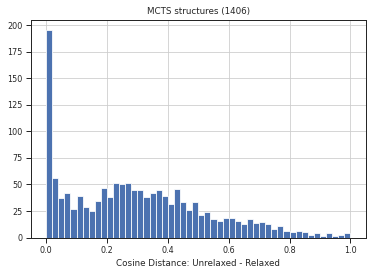

In [256]:
run_data.unrel_rel_cos_dist.hist(bins=50)
plt.xlabel("Cosine Distance: Unrelaxed - Relaxed")
plt.title(f"MCTS structures ({len(run_data)})")

In [257]:
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022_05_17_combined.p"
run_data.to_pickle(out_file)

In [ ]:
# create the inputs for these structures

In [13]:
def build_dataset(model_inputs, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: (s for s in model_inputs),
        output_signature=(preprocessor.output_signature),
        ).padded_batch(
            batch_size=batch_size,
            padding_values=(preprocessor.padding_values),
        )
    return dataset

In [139]:
from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor
from collections import Counter

def scale_by_pred_vol(structure):
    # first predict the volume using the average volume per element (from ICSD)
    try:
        site_counts = pd.Series(Counter(
            str(site.specie) for site in structure.sites)).fillna(0)
    except AttributeError:
        print(structure)
    curr_site_bias = site_bias[
        site_bias.index.isin(site_counts.index)]
    linear_pred = site_counts @ curr_site_bias
    structure.scale_lattice(linear_pred)

    # then apply Pymatgen's DLS predictor
    pred_volume = dls_vol_predictor.predict(structure)
    structure.scale_lattice(pred_volume)
    return structure

dls_vol_predictor = DLSVolumePredictor()
vol_pred_site_bias_file = "/projects/rlmolecule/pstjohn/crystal_inputs/site_volumes_from_icsd.csv"
site_bias = pd.read_csv(vol_pred_site_bias_file,
                        index_col=0, squeeze=True)

In [230]:
# apply the linear + DLS predicted volume to these structure
run_data['unrel_strc_predvol'] = run_data['unrel_structure'].progress_apply(scale_by_pred_vol)

  0%|          | 0/1406 [00:00<?, ?it/s]

In [231]:
# the structures already have the linear+DLS predicted volume, so just need to make the prediction now
run_data['inputs'] = run_data.unrel_strc_predvol.progress_apply(preprocessor)
# dataset = build_dataset(run_data.inputs, 8)
# predicted_energy = energy_model.predict(dataset)
# df['vol_model_pred'] = predicted_energy

  0%|          | 0/1406 [00:00<?, ?it/s]

In [252]:
def split_comp_to_eles_and_type(comp: str):
    """
    Extract the elements and composition type from a given composition
    e.g., _1_1_4 from Li1Sc1F4
    """
    # this splits by the digits
    # e.g., for "Li1Sc1F4": ['Li', '1', 'Sc', '1', 'F', '4', '']
    comp = comp.replace(' ','')
    split = np.asarray(re.split('(\d+)', comp))
    elements = tuple(sorted(split[range(0, len(split) - 1, 2)]))
    stoich = split[range(1, len(split), 2)]
    # sort the stoichiometry to get the correct order of the comp type
    comp_type = '_' + '_'.join(map(str, sorted(map(int, stoich))))
    return elements, comp_type


def get_comp_type(comp):
    """ Extract the composition type from the composition_id
    e.g., Ac1 Al11 Mg17 would be _1_11_17
    """
    elements, comp_type = split_comp_to_eles_and_type(comp)
    return comp_type

get_comp_type("Ac1 Mg17 Al11")

'_1_11_17'

In [253]:
run_data['dls_volume'] = run_data.unrel_strc_predvol.apply(lambda x: x.volume)
run_data['comptype'] = run_data.comp.apply(get_comp_type)
run_data.head(2)

,run_id,comp,energyperatom,decomp_energy,reward,unrel_structure,rel_structure,num_sites,volume,unrel_volume,proto_id,unrel_feats,rel_feats,unrel_rel_cos_dist,unrel_strc_predvol,inputs,pred_energyperatom,dls_volume,comptype
id,,,,,,,,,,,,,,,,,,,
K1Al2Br7_sg14_icsd_200871_1,20220504/batt-icsd-volpred-KLiNa,K1Al2Br7,-3.291,-1.087,1.045,"[[ 4.02869029 8.40396858 11.17619603] Al, [ 1...","[[ 4.12377755 8.73829064 10.7814738 ] Al, [ 1...",40,1844.334991,1884.372704,icsd_200871,"[0.08897724107874165, 0.07112465599077786, 0.0...","[0.1891294245126535, 0.15550724036692107, 0.18...",0.052979,"[[ 4.02869029 8.40396858 11.17619603] Al, [ 1...","{'site': [27, 27, 27, 27, 27, 27, 27, 27, 30, ...",-3.248333,1884.372704,_1_2_7
K1Hf1Br5_sg62_icsd_418675_1,20220504/batt-icsd-volpred-KLiNa,K1Hf1Br5,-4.008,-1.179,1.141,"[[10.45793139 5.98740196 9.68849231] K, [2.8...","[[11.61457197 5.78901635 8.17100474] K, [3.5...",28,1150.927561,1372.259840,icsd_418675,"[0.5716260895566027, 0.4946437690506922, 0.571...","[0.30475313061080306, 0.3322921837528992, 0.30...",0.187984,"[[10.45793139 5.98740196 9.68849231] K, [2.8...","{'site': [30, 30, 30, 30, 2, 2, 2, 2, 52, 52, ...",-3.968992,1372.259840,_1_1_5


In [269]:
print(len(run_data.index.drop_duplicates(keep="first")))
print(len(run_data.index.drop_duplicates(keep="first")))

1266

In [254]:
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022_05_17_combined_dls_vol.p"
run_data.to_pickle(out_file)

### Compare what the predicted energy would have been for the GNN trained on volume-relaxed structures only

In [232]:
base_dir = "/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork"
config_files = [
    # "config/batt_volunrel/battery-volunrelaxed-volperatom.yaml",
    # "config/batt_volunrel/battery-volunrelaxed.yaml",
    # "config/batt_volunrel/battery-volunrelaxed-dls1.5.yaml",
    # "config/batt_volunrel/no_2xbound_volperatom.yaml",
    # "config/batt_volunrel/no_2xbound.yaml",
    # "config/20220504-batt-volunrel/no_2xbound_volperatom.yaml",
    # "config/icsd_batt_vol/icsd_batt_vol.yaml",
    # "config/icsd_batt_vol/icsd_batt_vol_volpred.yaml",
    "config/20220504/icsd_batt_vol/icsd_batt_vol.yaml",
]

results = []
for config_file in config_files:
    config_map = utils.load_config_file(config_file)
    experiments = utils.get_experiments(config_map['experiments'])
    out_dir = utils.get_out_dir(config_map, experiments[0])
    print(config_file, out_dir)
    
    inputs_dir = Path(out_dir).parents[0]
    preprocessor = PymatgenPreprocessor()
    preprocessor_file = inputs_dir / "preprocessor.json"
    print(f"reading {preprocessor_file}")
    preprocessor.from_json(preprocessor_file)
    # results += eval_test.main(config_map)
    model_file = Path(model_dir, "best_model.hdf5")
    print(f"Reading {model_file}")
    model = tf.keras.models.load_model(
        model_file,
        custom_objects={
            **custom_objects,
            **{'RBFExpansion': RBFExpansion},
            })

    batch_size = 64
    test_dataset = build_dataset(run_data.inputs, batch_size)

    predictions = model.predict(test_dataset)
    data_col = 'energyperatom'
    pred_col = f'pred_{data_col}'
    run_data[pred_col] = predictions
    

Loading config file 'config/20220504/icsd_batt_vol/icsd_batt_vol.yaml'
config/20220504/icsd_batt_vol/icsd_batt_vol.yaml outputs/2022_05_04/icsd_battrel_vol_pred_vol/randsub0_05_randsub0_05_holdout_match_seed1
reading outputs/2022_05_04/icsd_battrel_vol_pred_vol/preprocessor.json
Reading /projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork/outputs/2022_05_04/icsd_battrel_vol_pred_vol/randsub0_05_randsub0_05_holdout_match_seed1/best_model.hdf5


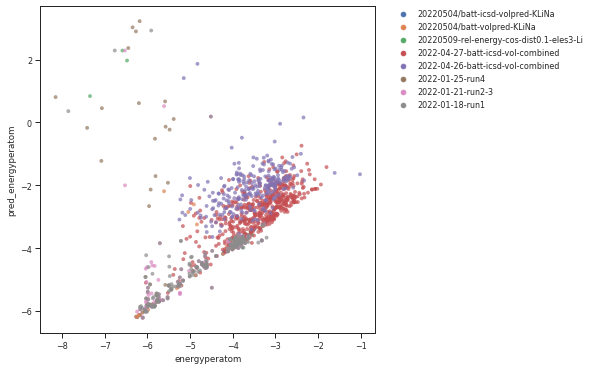

In [168]:
f, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=run_data, x=data_col, y=pred_col, ax=ax,
                hue="run_id", alpha=0.7, linewidth=0, s=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'MCTS structures (1406)')

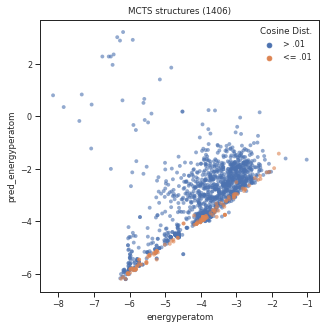

In [262]:
df = run_data.copy()
df['Cosine Dist.'] = ["> .01" if x == 1 else "<= .01" for x in np.digitize(df['unrel_rel_cos_dist'].values, [0.01])]
df = df.sort_values('Cosine Dist.', ascending=False)

f, ax = plt.subplots(figsize=(5,5))
g = sns.scatterplot(data=df, x=data_col, y=pred_col, ax=ax,
                    hue="Cosine Dist.", hue_order=["> .01", "<= .01"],
                    alpha=0.6, linewidth=0, s=15)

plt.title(f"MCTS structures ({len(df)})")

In [275]:
df.columns

Index(['run_id', 'comp', 'energyperatom', 'decomp_energy', 'reward',
       'unrel_structure', 'rel_structure', 'num_sites', 'volume',
       'unrel_volume', 'proto_id', 'unrel_feats', 'rel_feats',
       'unrel_rel_cos_dist', 'unrel_strc_predvol', 'inputs',
       'pred_energyperatom', 'dls_volume', 'comptype', 'Cosine Dist.'],
      dtype='object')

In [281]:
sns.set_style("whitegrid")

Text(0.5, 1.0, 'MCTS structures (36)')

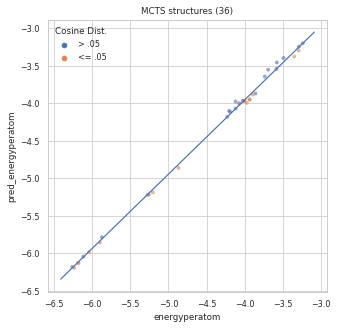

In [284]:
df = run_data.copy()
df = df[df['run_id'] == "20220504/batt-icsd-volpred-KLiNa"]
df['Cosine Dist.'] = ["> .05" if x == 1 else "<= .05" for x in np.digitize(df['unrel_rel_cos_dist'].values, [0.05])]
df = df.sort_values('Cosine Dist.', ascending=False)

f, ax = plt.subplots(figsize=(5,5))
g = sns.scatterplot(data=df, x=data_col, y=pred_col, ax=ax,
                    hue="Cosine Dist.", hue_order=["> .05", "<= .05"],
                    alpha=0.6, linewidth=0, s=15)
# plt.ylim(-4.5, -3)
# plt.xlim(-4.5, -3)
plt.plot(plt.xlim(), plt.ylim())

plt.title(f"MCTS structures ({len(df)})")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


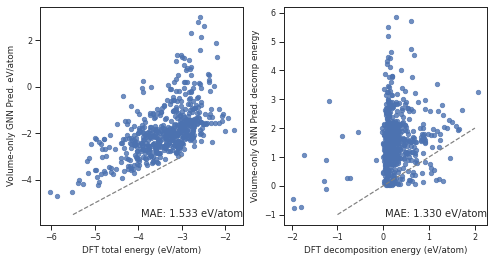

In [48]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax = ax1
pred_col = "vol_model_pred"
df.plot.scatter(x="energyperatom", y=pred_col, ax=ax,
                alpha=0.8,
               )
ax.plot([-5.5,-3], [-5.5,-3], ls='--', c='gray')
ax.set_xlabel("DFT total energy (eV/atom)")
ax.set_ylabel("Volume-only GNN Pred. eV/atom")
mae = (df['energyperatom'] - df[pred_col]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

ax = ax2
df.plot.scatter(x="decomp_energy", y="volpred_decomp_energy", ax=ax,
                alpha=0.8,
               )
ax.plot([-1,2], [-1,2], ls='--', c='gray')
ax.set_xlabel("DFT decomposition energy (eV/atom)")
ax.set_ylabel("Volume-only GNN Pred. decomp energy")
mae = (df['decomp_energy'] - df["volpred_decomp_energy"]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

plt.show()
plt.close()

In [55]:
# make sure to load the preprocessor that was used for 
preprocessor = PymatgenPreprocessor()
#preprocessor.from_json(Path(inputs_dir, "preprocessor.json"))
# TODO preprocessor should match the data files
# preprocessor should be in the same dir as the data files
preprocessor.from_json(Path(model_dir, "../preprocessor.json"))

energy_model_file = Path(model_dir, "best_model.hdf5")
print(f"loading {energy_model_file}")
energy_model = tf.keras.models.load_model(energy_model_file,
                                          custom_objects={**custom_objects,
                                                          **{'RBFExpansion': RBFExpansion}})

loading /projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork/outputs/2022_05_04/icsd_battrel_vol_pred_vol/randsub0_05_randsub0_05_holdout_match_seed1/best_model.hdf5


In [56]:
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-04-27-batt-icsd-vol-combined"
pred_file = Path(out_dir, "viz/pred_vs_dft.csv")
df = pd.read_csv(pred_file, index_col=0)
df.head()

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff
0,Na1Cd1Cl1Br2/Na1Cd1Cl1Br2_sg140_icsd_411137_3,20,630.07,-2.383,Na1Cd1Cl1Br2,Na1Cd1Cl1Br2_sg140_icsd_411137_3,0.339,-5.307761,-2.587,2.924761
1,Li2F1Cl1/Li2F1Cl1_sg180_icsd_090403_1,12,210.74,-4.183,Li2F1Cl1,Li2F1Cl1_sg180_icsd_090403_1,0.085,-6.786662,-2.521,2.603662
2,Na5Al1S4/Na5Al1S4_sg36_icsd_016987_1,40,1040.90,-3.734,Na5Al1S4,Na5Al1S4_sg36_icsd_016987_1,0.109,-6.322466,-2.481,2.588466
3,Mg1Zr1Cl4S1/Mg1Zr1Cl4S1_sg8_icsd_086792_2,14,401.21,-4.495,Mg1Zr1Cl4S1,Mg1Zr1Cl4S1_sg8_icsd_086792_2,0.107,-6.883161,-2.283,2.388161
4,Na1Cd1Cl2Br1/Na1Cd1Cl2Br1_sg12_icsd_172782_1,20,610.00,-2.784,Na1Cd1Cl2Br1,Na1Cd1Cl2Br1_sg12_icsd_172782_1,0.047,-6.187317,-3.359,3.403317


In [57]:
# load the structures
strc_dir = Path(out_dir, "best_decorations")
def load_structure(strc_id):
# for strc_id in df.id:
    strc_file = Path(strc_dir, "POSCAR_" + strc_id)
    strc = None
    if strc_file.is_file():
        strc = Structure.from_file(strc_file, primitive=True)
    return strc

df['structure'] = df.id.progress_apply(load_structure)
df.head(2)

  0%|          | 0/534 [00:00<?, ?it/s]

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff,structure
0,Na1Cd1Cl1Br2/Na1Cd1Cl1Br2_sg140_icsd_411137_3,20,630.07,-2.383,Na1Cd1Cl1Br2,Na1Cd1Cl1Br2_sg140_icsd_411137_3,0.339,-5.307761,-2.587,2.924761,"[[3.937038 0. 2.777679] Cd, [3.937038 0...."
1,Li2F1Cl1/Li2F1Cl1_sg180_icsd_090403_1,12,210.74,-4.183,Li2F1Cl1,Li2F1Cl1_sg180_icsd_090403_1,0.085,-6.786662,-2.521,2.603662,"[[1.1532705 1.997523 5.52217279] F, [2.3065..."


In [13]:
def build_dataset(model_inputs, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: (s for s in model_inputs),
        output_signature=(preprocessor.output_signature),
        ).padded_batch(
            batch_size=batch_size,
            padding_values=(preprocessor.padding_values),
        )
    return dataset

In [14]:
# the structures already have the linear+DLS predicted volume, so just need to make the prediction now
df['inputs'] = df.structure.progress_apply(preprocessor)

dataset = build_dataset(df.inputs, 8)
predicted_energy = energy_model.predict(dataset)
df['vol_model_pred'] = predicted_energy

  0%|          | 0/534 [00:00<?, ?it/s]

In [17]:
from scripts import ehull

def compute_decomp_energy(structure, predicted_energy, df_competing_phases):
    comp = structure.composition.reduced_composition.alphabetical_formula.replace(' ', '')
    # update: if the composition is in the competing phases,
    # then just compare the predicted energy to the energy of the competing phase
    if comp in df_competing_phases['reduced_composition']:
        competing_energy = df_competing_phases.set_index(
            'reduced_composition').loc[comp].energyperatom
        decomp_energy = predicted_energy - competing_energy
    else:
        decomp_energy = ehull.convex_hull_stability(comp,
                                                    predicted_energy,
                                                    df_competing_phases)
    return decomp_energy

df_competing_phases = pd.read_csv('inputs/competing_phases.csv')
print(f"\t{len(df_competing_phases)} lines")
print(df_competing_phases.head(2))

	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4


In [18]:
# also compute what the decomposition energy would be
df['volpred_decomp_energy'] = df.progress_apply(
    lambda row: compute_decomp_energy(row.structure,
                                      row.vol_model_pred,
                                      df_competing_phases),
    axis=1)

  0%|          | 0/534 [00:00<?, ?it/s]

exception '_cdd.error' not a BaseException subclass
Failed at stability.run_stability for Cl2N2Na4Si1 (pred_energy: -1.6001025438308716). Skipping

exception '_cdd.error' not a BaseException subclass
Failed at stability.run_stability for Cl4N1Na3Si1 (pred_energy: -1.7361335754394531). Skipping



In [15]:
df.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff,structure,inputs,vol_model_pred
0,Na1Cd1Cl1Br2/Na1Cd1Cl1Br2_sg140_icsd_411137_3,20,630.07,-2.383,Na1Cd1Cl1Br2,Na1Cd1Cl1Br2_sg140_icsd_411137_3,0.339,-5.307761,-2.587,2.924761,"[[3.937038 0. 2.777679] Cd, [3.937038 0....","{'site': [18, 18, 18, 18, 10, 10, 10, 10, 4, 4...",0.209111
1,Li2F1Cl1/Li2F1Cl1_sg180_icsd_090403_1,12,210.74,-4.183,Li2F1Cl1,Li2F1Cl1_sg180_icsd_090403_1,0.085,-6.786662,-2.521,2.603662,"[[1.1532705 1.997523 5.52217279] F, [2.3065...","{'site': [11, 11, 11, 2, 2, 2, 8, 8, 8, 8, 8, ...",-3.418234


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


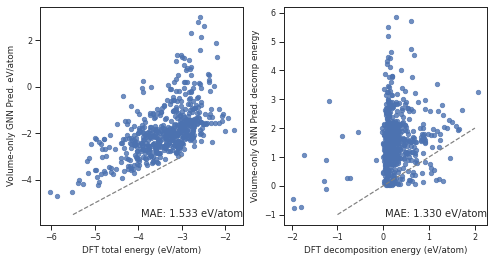

In [48]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax = ax1
pred_col = "vol_model_pred"
df.plot.scatter(x="energyperatom", y=pred_col, ax=ax,
                alpha=0.8,
               )
ax.plot([-5.5,-3], [-5.5,-3], ls='--', c='gray')
ax.set_xlabel("DFT total energy (eV/atom)")
ax.set_ylabel("Volume-only GNN Pred. eV/atom")
mae = (df['energyperatom'] - df[pred_col]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

ax = ax2
df.plot.scatter(x="decomp_energy", y="volpred_decomp_energy", ax=ax,
                alpha=0.8,
               )
ax.plot([-1,2], [-1,2], ls='--', c='gray')
ax.set_xlabel("DFT decomposition energy (eV/atom)")
ax.set_ylabel("Volume-only GNN Pred. decomp energy")
mae = (df['decomp_energy'] - df["volpred_decomp_energy"]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

plt.show()
plt.close()

## Repeat for the icsd + relaxed + vol-relaxed model

In [19]:
base_dir = "/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork"
model_dir = Path(base_dir, "outputs/20220422_batt_icsd_and_volunrelax-2")
# model_dir = 

In [20]:
# make sure to load the preprocessor that was used for 
preprocessor = PymatgenPreprocessor()
#preprocessor.from_json(Path(inputs_dir, "preprocessor.json"))
# TODO preprocessor should match the data files
# preprocessor should be in the same dir as the data files
preprocessor.from_json(Path(model_dir, "preprocessor.json"))

energy_model_file = Path(model_dir, "best_model.hdf5")
print(f"loading {energy_model_file}")
energy_model = tf.keras.models.load_model(energy_model_file,
                                          custom_objects={**custom_objects,
                                                          **{'RBFExpansion': RBFExpansion}})

loading /projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork/outputs/20220422_batt_icsd_and_volunrelax-2/best_model.hdf5


In [21]:
# the structures already have the linear+DLS predicted volume, so just need to make the prediction now
predicted_energy = energy_model.predict(dataset)
df['fixed_pred_epa'] = predicted_energy

In [22]:
# also compute what the decomposition energy would be
df['fixed_pred_decomp_energy'] = df.progress_apply(
    lambda row: compute_decomp_energy(row.structure,
                                      row.fixed_pred_epa,
                                      df_competing_phases),
    axis=1)

  0%|          | 0/534 [00:00<?, ?it/s]

exception '_cdd.error' not a BaseException subclass
Failed at stability.run_stability for Cl2N2Na4Si1 (pred_energy: -2.12191104888916). Skipping

exception '_cdd.error' not a BaseException subclass
Failed at stability.run_stability for Cl4N1Na3Si1 (pred_energy: -2.635756492614746). Skipping



In [23]:
df.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff,structure,inputs,vol_model_pred,volpred_decomp_energy,fixed_pred_epa,fixed_pred_decomp_energy
0,Na1Cd1Cl1Br2/Na1Cd1Cl1Br2_sg140_icsd_411137_3,20,630.07,-2.383,Na1Cd1Cl1Br2,Na1Cd1Cl1Br2_sg140_icsd_411137_3,0.339,-5.307761,-2.587,2.924761,"[[3.937038 0. 2.777679] Cd, [3.937038 0....","{'site': [18, 18, 18, 18, 10, 10, 10, 10, 4, 4...",0.209111,1.705,-1.999254,0.723
1,Li2F1Cl1/Li2F1Cl1_sg180_icsd_090403_1,12,210.74,-4.183,Li2F1Cl1,Li2F1Cl1_sg180_icsd_090403_1,0.085,-6.786662,-2.521,2.603662,"[[1.1532705 1.997523 5.52217279] F, [2.3065...","{'site': [11, 11, 11, 2, 2, 2, 8, 8, 8, 8, 8, ...",-3.418234,0.849,-3.806172,0.461


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


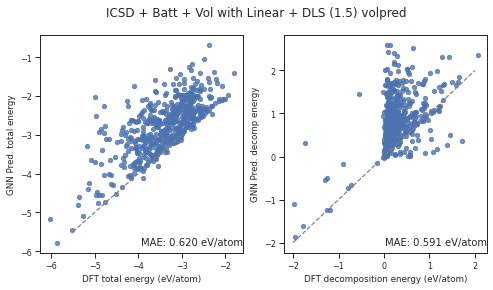

In [47]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax = ax1
df.plot.scatter(x="energyperatom", y="fixed_pred_epa", ax=ax,
                alpha=0.8,
               )
ax.plot([-5.5,-3], [-5.5,-3], ls='--', c='gray')
ax.set_xlabel("DFT total energy (eV/atom)")
ax.set_ylabel("GNN Pred. total energy")
mae = (df['energyperatom'] - df["fixed_pred_epa"]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

ax = ax2
df.plot.scatter(x="decomp_energy", y="fixed_pred_decomp_energy", ax=ax,
                alpha=0.8,
               )
ax.plot([-2,2], [-2,2], ls='--', c='gray')
ax.set_xlabel("DFT decomposition energy (eV/atom)")
ax.set_ylabel("GNN Pred. decomp energy")
mae = (df['decomp_energy'] - df["fixed_pred_decomp_energy"]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

plt.suptitle("ICSD + Batt + Vol with Linear + DLS (1.5) volpred")

plt.show()
plt.close()

## Repeat again for normalized input structures

In [32]:
base_dir = "/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork"
model_dir = Path(base_dir, "outputs/20220422_batt_icsd_and_volunrelax_norm")

In [33]:
# make sure to load the preprocessor that was used for 
preprocessor = PymatgenPreprocessor()
#preprocessor.from_json(Path(inputs_dir, "preprocessor.json"))
# TODO preprocessor should match the data files
# preprocessor should be in the same dir as the data files
preprocessor.from_json(Path(model_dir, "preprocessor.json"))

energy_model_file = Path(model_dir, "best_model.hdf5")
print(f"loading {energy_model_file}")
energy_model = tf.keras.models.load_model(energy_model_file,
                                          custom_objects={**custom_objects,
                                                          **{'RBFExpansion': RBFExpansion}})

loading /projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-fork/outputs/20220422_batt_icsd_and_volunrelax_norm/best_model.hdf5


In [39]:
def scale_to_min_dist(inputs):
    inputs["distance"] /= inputs["distance"].min()
    return inputs

In [41]:
df['inputs_norm'] = df.inputs.copy().apply(scale_to_min_dist)

dataset_norm = build_dataset(df.inputs_norm, 8)
predicted_energy = energy_model.predict(dataset_norm)
pred_col = 'norm_pred_epa'
df[pred_col] = predicted_energy

In [49]:
# also compute what the decomposition energy would be
df['norm_pred_decomp_energy'] = df.progress_apply(
    lambda row: compute_decomp_energy(row.structure,
                                      row[pred_col],
                                      df_competing_phases),
    axis=1)

  0%|          | 0/534 [00:00<?, ?it/s]

exception '_cdd.error' not a BaseException subclass
Failed at stability.run_stability for Cl2N2Na4Si1 (pred_energy: -1.6001025438308716). Skipping

exception '_cdd.error' not a BaseException subclass
Failed at stability.run_stability for Cl4N1Na3Si1 (pred_energy: -1.7361335754394531). Skipping



In [51]:
df.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff,structure,inputs,vol_model_pred,volpred_decomp_energy,fixed_pred_epa,fixed_pred_decomp_energy,norm_pred_epa,norm_pred_decomp_energy,inputs_norm
0,Na1Cd1Cl1Br2/Na1Cd1Cl1Br2_sg140_icsd_411137_3,20,630.07,-2.383,Na1Cd1Cl1Br2,Na1Cd1Cl1Br2_sg140_icsd_411137_3,0.339,-5.307761,-2.587,2.924761,"[[3.937038 0. 2.777679] Cd, [3.937038 0....","{'site': [18, 18, 18, 18, 10, 10, 10, 10, 4, 4...",0.209111,1.705,-1.999254,0.723,-1.977171,1.705,"{'site': [18, 18, 18, 18, 10, 10, 10, 10, 4, 4..."
1,Li2F1Cl1/Li2F1Cl1_sg180_icsd_090403_1,12,210.74,-4.183,Li2F1Cl1,Li2F1Cl1_sg180_icsd_090403_1,0.085,-6.786662,-2.521,2.603662,"[[1.1532705 1.997523 5.52217279] F, [2.3065...","{'site': [11, 11, 11, 2, 2, 2, 8, 8, 8, 8, 8, ...",-3.418234,0.849,-3.806172,0.461,-3.806314,0.849,"{'site': [11, 11, 11, 2, 2, 2, 8, 8, 8, 8, 8, ..."


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


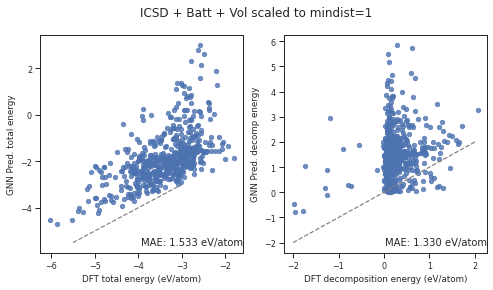

In [52]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax = ax1
df.plot.scatter(x="energyperatom", y=pred_col, ax=ax,
                alpha=0.8,)
ax.plot([-5.5,-3], [-5.5,-3], ls='--', c='gray')
ax.set_xlabel("DFT total energy (eV/atom)")
ax.set_ylabel("GNN Pred. total energy")
mae = (df['energyperatom'] - df[pred_col]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

ax = ax2
df.plot.scatter(x="decomp_energy", y="norm_pred_decomp_energy", ax=ax,
                alpha=0.8,)
ax.plot([-2,2], [-2,2], ls='--', c='gray')
ax.set_xlabel("DFT decomposition energy (eV/atom)")
ax.set_ylabel("GNN Pred. decomp energy")
mae = (df['decomp_energy'] - df["norm_pred_decomp_energy"]).abs().mean()
ax.text(1, 0.025, f'MAE: {mae:.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

plt.suptitle("ICSD + Batt + Vol scaled to mindist=1")

plt.show()
plt.close()